In [2]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Sep 24 2015, 00:07:46) 
[GCC 4.4.5 20110214 (Red Hat 4.4.5-6)]
sys.platform    linux2
sys.maxsize     9223372036854775807
numpy   1.10.1



In [4]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)

<module 'chebyshev' from '../cbcrom/chebyshev.pyc'>

# Get training set

In [14]:
# training_set_dir = '/home/bdlackey/cbcrom/training_set_cheb_3'
# ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_3/teob_runs_cheb_3_%d.hdf5'

# training_set_dir = '/home/bdlackey/cbcrom/training_set_cheb_9'
# ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_9/teob_runs_cheb_9_%d.hdf5'

training_set_dir = '/home/bdlackey/cbcrom/training_set_cheb_16'
ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_16/teob_runs_cheb_16_%d.hdf5'

# break up hdf5 file into 16GB chunks
memb_size=2**34-1
param_names = ['q', 'LambdaA', 'LambdaB']
ts = eob.get_eob_training_set_efficient(training_set_dir, ts_filename, memb_size=memb_size, regular_grid=True, 
                          param_names=param_names, 
                          t_transition=-1000.0, samples_per_cycle=2.0, dt=0.1, t_trunc=2.0e7)
ts.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [1]:
import glob
import operator
import scipy.interpolate

In [5]:
#training_set_dir = '/home/bdlackey/cbcrom/training_set_cheb_16'
training_set_dir = '../training_set_rand'

filenames = glob.glob(training_set_dir+'/*.h5')

# Number of waveforms
Nwave = len(filenames)

file_and_params = []
for filename in filenames:
    params = map(float, filename.split('/')[-1].split('.')[0].replace('p', '.').split('_')[-3:])
    file_and_params.append([filename]+params)

# Convert mass ratio bigq to smallq
for i in range(Nwave):
    bigq = file_and_params[i][1]
    file_and_params[i][1] = 1.0/bigq

# Sort the waveforms by their parameter values
file_and_params_sorted = sorted(file_and_params, key=operator.itemgetter(1, 2, 3))
param_list = [file_and_params_sorted[i][1:] for i in range(Nwave)]

# # Create waveform set object
# waveform_set = tdwave.HDF5TimeDomainWaveformSet(ts_filename, mode='x', memb_size=memb_size)
# waveform_set.set_parameter_names(param_names)
# waveform_set.set_grid_shape(shape=regular_grid_shape)


In [7]:
filename = file_and_params_sorted[2329][0]

In [8]:
time, amp, phase = eob.time_amp_phase_from_filename(filename)
h = tdwave.TimeDomainWaveform(time, amp, phase)

(0, 70000000.0)

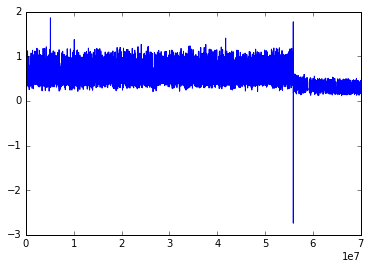

In [15]:
fig, axes = plt.subplots()
axes.plot(h.time[1:], h.phase[1:]-h.phase[:-1])
axes.set_xlim(0, 7.0e7)
#axes.set_ylim(-10, 10000)

In [9]:
h.time[-1]

237185117.51304191

In [74]:
# Truncate the first t_trunc of the waveform
h = eob.truncate_beginning(h, t_trunc)
# Align at max amplitude.
tatmax = eob.time_at_max_amp(h.time, h.amp)

In [76]:
h.time[-1], tatmax

(238228259.13565952, 238228239.68045485)

In [77]:
h.time_shift(-tatmax)

In [78]:
h.time[-1]

19.455204665660858

In [79]:
h.remove_decreasing_phase()

In [80]:
h.time[-1]

-233751497.59178334

In [61]:
t_transition=-1000.0
samples_per_cycle=100.0
dt=0.1
t_trunc=1.0e5

# Truncate the first t_trunc of the waveform
h = eob.truncate_beginning(h, t_trunc)
# Align at max amplitude.
tatmax = eob.time_at_max_amp(h.time, h.amp)
h.time_shift(-tatmax)
# Remove decreasing phase
h.remove_decreasing_phase()

In [68]:
def uniform_in_phase_then_time(h, t_start, t_end, t_transition, samples_per_cycle, dt, order=2):
    """Resample waveform with spacing uniform in phase at the beginning, 
    then transition to uniform in time at the end.
    """
    # Remove points at the end where the phase is decreasing.
    h.remove_decreasing_phase()

    # Check that t_start and t_end are in the range of h.time
    if t_start<h.time[0] or t_end>h.time[-1]:
        raise Exception, 'Start and end times must be in the range of h.time.'

    # Interpolate time(phase)
    tofphase = scipy.interpolate.UnivariateSpline(h.phase, h.time, k=order, s=0)
    ampoft = scipy.interpolate.UnivariateSpline(h.time, h.amp, k=order, s=0)
    phaseoft = scipy.interpolate.UnivariateSpline(h.time, h.phase, k=order, s=0)

    # Uniform phase samples
    phi_start = phaseoft(t_start)
    phi_transition = phaseoft(t_transition)
    #phase = np.arange(phi_start, phi_end, 2.0*np.pi/samples_per_cycle)
    npoints = int(np.ceil((phi_transition - phi_start)*samples_per_cycle/(2.0*np.pi))) + 1
    phase = np.linspace(phi_start, phi_transition, npoints)
    # time samples
    time_a = tofphase(phase)
    time_a[0] = t_start # Make sure this is exactly as requested (not just approximate)

    # Uniform time samples
    npoints = int(np.ceil( (t_end-(t_transition+dt))/dt ))
    print npoints, t_end, t_transition
    time_b = np.linspace(t_transition+dt, t_end, npoints)

    h.time = np.concatenate((time_a, time_b))
    h.amp = ampoft(h.time)
    h.phase = phaseoft(h.time)


In [70]:
h.time[-1]

-233751497.59178334

In [69]:
t_transition=-1000.0
samples_per_cycle=100.0
dt=0.1
t_trunc=1.0e5
uniform_in_phase_then_time(h, h.time[0], h.time[-1], t_transition, samples_per_cycle, dt, order=2)

-2337504976 -233751497.592 -1000.0


ValueError: Number of samples, -2337504976, must be non-negative.

In [49]:
t_transition=-1000.0
samples_per_cycle=100.0
dt=0.1
t_trunc=1.0e5

# Truncate the first t_trunc of the waveform
h = eob.truncate_beginning(h, t_trunc)
# Align at max amplitude.
tatmax = eob.time_at_max_amp(h.time, h.amp)
h.time_shift(-tatmax)
# Remove decreasing phase
h.remove_decreasing_phase()
uniform_in_phase_then_time(h, h.time[0], h.time[-1], t_transition, samples_per_cycle, dt, order=2)


ValueError: Number of samples, -2337504976, must be non-negative.

In [50]:
tatmax

238228239.68045485

In [51]:
h.time[0]

-238128014.64716411

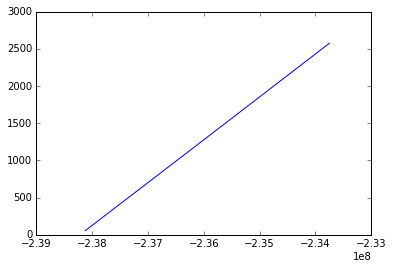

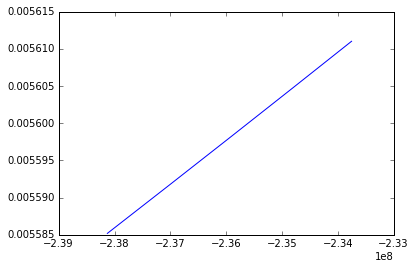

In [83]:
fig, axes = plt.subplots()
axes.plot(h.time, h.phase)
#axes.set_xlim(0, 1.0e6)
#axes.set_ylim(-10, 1000)

fig, axes = plt.subplots()
axes.plot(h.time, h.amp)

In [7]:
filenames = glob.glob(training_set_dir+'/*.h5')

    # Number of waveforms
    Nwave = len(filenames)

    file_and_params = []
    for filename in filenames:
        params = map(float, filename.split('/')[-1].split('.')[0].replace('p', '.').split('_')[-3:])
        file_and_params.append([filename]+params)

    # Convert mass ratio bigq to smallq
    for i in range(Nwave):
        bigq = file_and_params[i][1]
        file_and_params[i][1] = 1.0/bigq

    # Sort the waveforms by their parameter values
    file_and_params_sorted = sorted(file_and_params, key=operator.itemgetter(1, 2, 3))
    param_list = [file_and_params_sorted[i][1:] for i in range(Nwave)]

    if regular_grid:
        # Make a regular grid of parameters
        params_array = np.array(param_list)
        # Set gives a dictionary of unique elements in a list
        Nparams = len(params_array[0,:])
        regular_grid_shape = [len(set(params_array[:,i])) for i in range(Nparams)]
        #params_grid = params_array.reshape(tuple(regular_grid_shape+[Nparams]))
    else:
        regular_grid_shape = None

    # Create waveform set object
    waveform_set = tdwave.HDF5TimeDomainWaveformSet(ts_filename, mode='x', memb_size=memb_size)
    waveform_set.set_parameter_names(param_names)
    waveform_set.set_grid_shape(shape=regular_grid_shape)

    ########### Get all waveforms, do time shift, clean them up, then place them in a common object. ##########
    tstartlist = []
    tendlist = []
    for i in range(Nwave):
        #if i%100==0: print i,
        print i,
        # Import waveform.
        filename = file_and_params_sorted[i][0]
        time, amp, phase = time_amp_phase_from_filename(filename)
        h = tdwave.TimeDomainWaveform(time, amp, phase)

NameError: name 'ts' is not defined

In [4]:
#ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_3/teob_runs_cheb_3_%d.hdf5'
#ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_9/teob_runs_cheb_9_%d.hdf5'
ts_filename = '/home/bdlackey/cbcrom/training_set_cheb_16/teob_runs_cheb_16_%d.hdf5'
memb_size=2**34-1
ts = tdwave.load_hdf5_time_domain_waveform_set(ts_filename, memb_size=memb_size)

# Test training set

[  5.00000000e-01   5.00000000e+01   4.78602501e+03]
-200737043.792


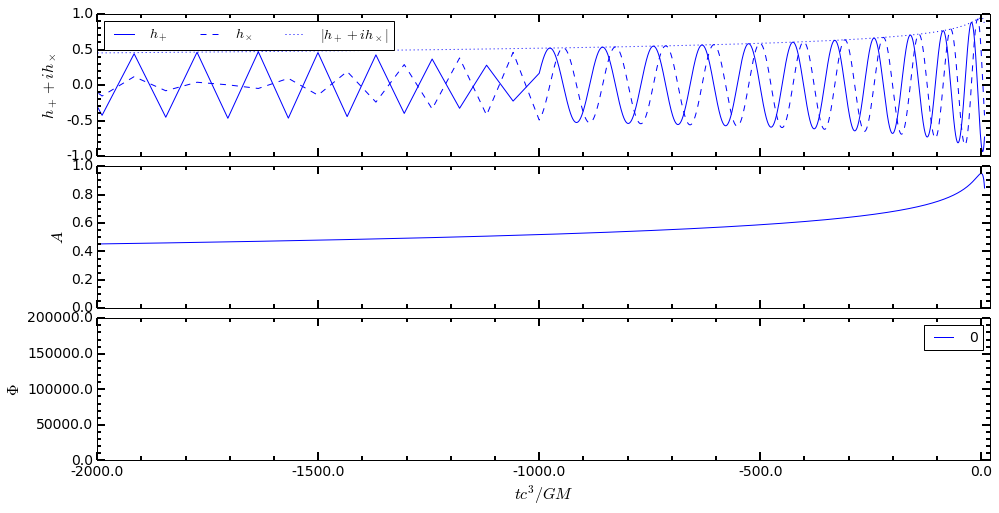

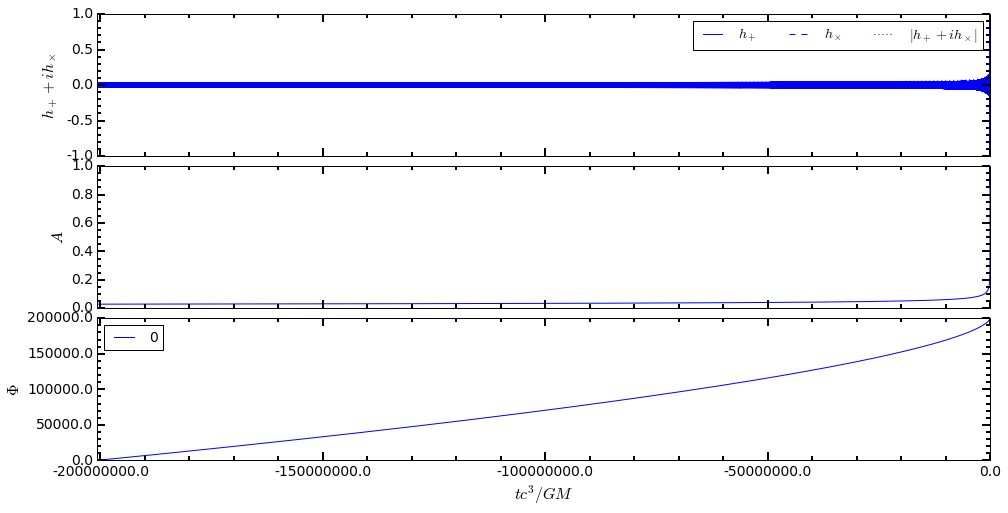

In [5]:
i=13
waveforms = ts.get_waveform_data(i)
print ts.get_waveform_data(i, data='parameters')

xlim=[-2000, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

xlim=[waveforms.time[0], waveforms.time[-1]]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

print waveforms.time[0]

(189000, 201000)

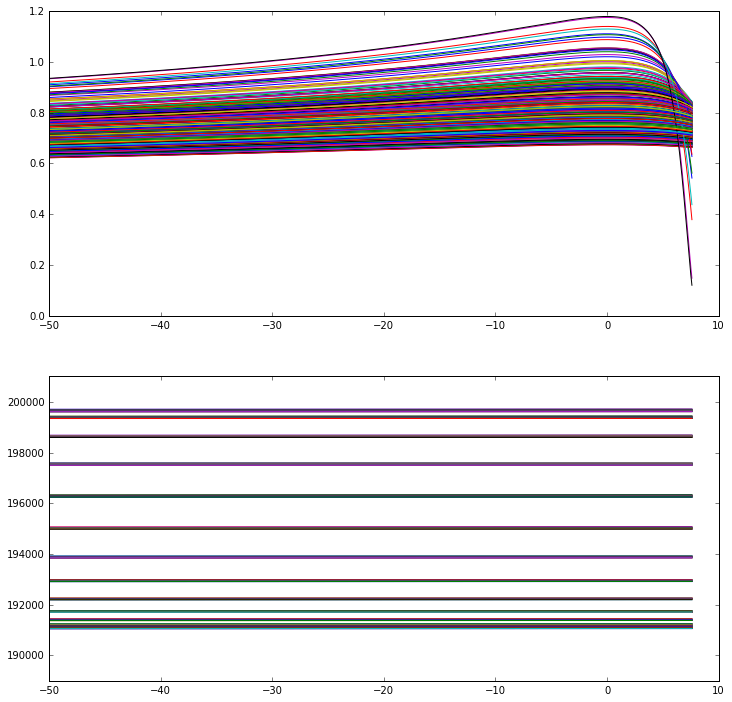

In [7]:
fig = plt.figure(figsize=(12, 12))

axes = fig.add_subplot(211)
#for i in range(0, ts.get_len(), 1):
for i in range(0, ts.get_len(), 10):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).amp, marker='')
axes.set_xlim([-50, 10])

axes = fig.add_subplot(212)
#for i in range(0, ts.get_len(), 1):
for i in range(0, ts.get_len(), 10):
    axes.plot(ts.get_waveform_data(i).time, ts.get_waveform_data(i).phase, marker='')
axes.set_xlim([-50, 10])
axes.set_ylim([180000, 210000])

# Make reduced basis

### Greedy algorithm for amplitude

In [8]:
#epsilon = 1.0e-15
epsilon = 1.0e-9

# Initialize the ReducedBasis object
add = tdwave.add_amp
subtract = tdwave.subtract_amp
scalar_multiply = tdwave.scalar_multiply_amp
#inner_product = tdwave.inner_product_amp_simps
#inner_product = tdwave.inner_product_amp
inner_product = tdwave.inner_product_amp_samples
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0103320510763
0.000308216503449
0.000105445529931
1.08415830913e-06
5.63821483834e-07
3.30012637884e-07
1.16968654096e-07
1.72382411678e-08
5.10691611222e-09
1.13835063598e-09
1.08510311847e-10


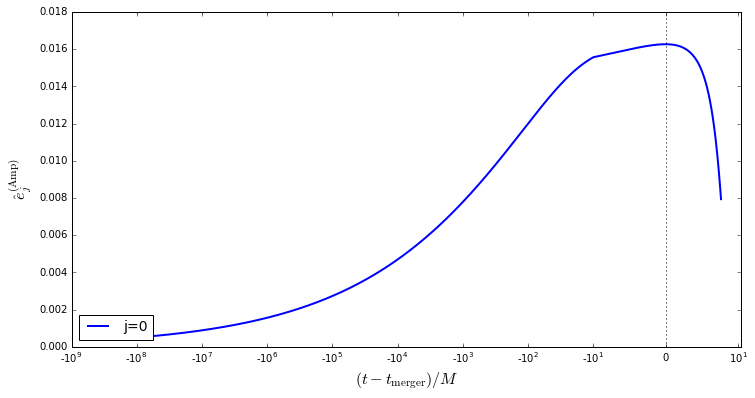

In [9]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(1):
    axes.plot(rbamprun.rb[j].time, rbamprun.rb[j].amp, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
#axes.set_ylim([-1.1, 1.1])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.0001)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)

In [10]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
#filename = '../data/teob_rbamp_smallq_cheb_3_%d.hdf5'
#filename = '../data/teob_rbamp_smallq_cheb_9_%d.hdf5'
filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
rbamp.set_parameter_names(param_names)
rbamp.set_grid_shape(shape=None)
rbamp.add_waveform_list(rbamprun.rb, rbamprun.rb_params)
rbamp.close()

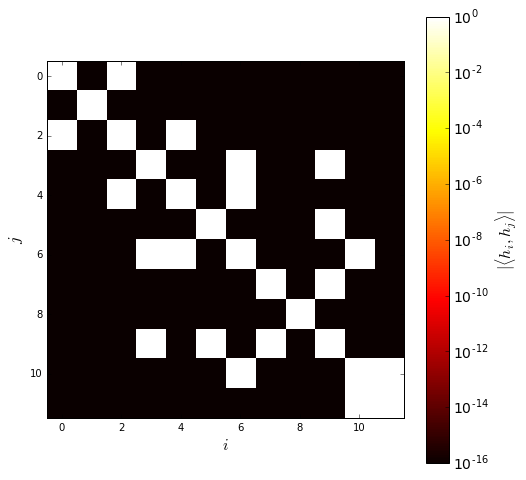

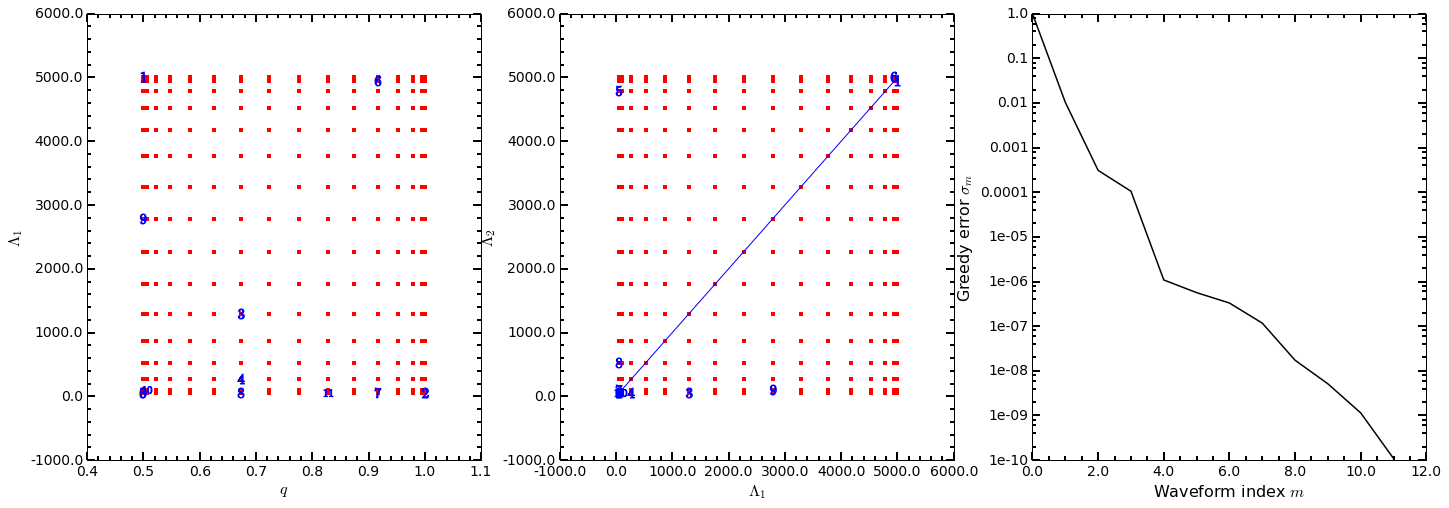

In [11]:
inner = diagnostics.check_orthonormality(rbamprun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbamprun.ts_params, rb_params=rbamprun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbamprun.sigma_list)

### Greedy algorithm for phase

In [12]:
# import scipy.integrate

# # def inner_product_phase_weighted(h1, h2):
# #     """Use Simpson's rule to
# #     evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
# #     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
# #     """
# #     #check_waveform_consistency(h1, h2)
# #     t = h1.time
# #     t0 = t[0]
# #     weight = t-t0+1.0
# #     integrand = weight*h1.phase*h2.phase
# #     return scipy.integrate.simps(integrand, x=h1.time)

# def inner_product_phase_weighted(h1, h2):
#     """Use Simpson's rule to
#     evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
#     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
#     """
#     #check_waveform_consistency(h1, h2)
#     t = h1.time
#     #weight = np.array([1.0e-8 if t[i]<-1.0e4 else 1.0 for i in range(len(t))])
#     #weight = np.array([0.0 if t[i]<-1.0e3 else 1.0 for i in range(len(t))])
#     #print weight
#     t0 = t[0]
#     weight = t-t0+1.0
#     #print weight
#     integrand = weight*h1.phase*h2.phase
#     return scipy.integrate.simps(integrand, x=h1.time)
    

# def abs_max_phase_func(h):
#     """
#     """
#     return np.max(np.abs(h.phase))

In [13]:
# def inner_product_phase_weighted_2(h1, h2):
#     """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
#     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
#     """
#     #check_waveform_consistency(h1, h2)
#     t = h1.time
#     #weight = np.array([1.0e-8 if t[i]<-1.0e4 else 1.0 for i in range(len(t))])
#     weight = np.array([0.0 if t[i]<-1.0e3 else 1.0 for i in range(len(t))])
#     integrand = weight*h1.phase*h2.phase
#     diff = np.array([h1.time[i+1]-h1.time[i] for i in range(len(h1.time)-1)])
#     sum_neighbors = np.array([integrand[i]+integrand[i+1] for i in range(len(integrand)-1)])
#     return 0.5*np.sum( diff * sum_neighbors )

# def inner_product_phase_weighted_3(h1, h2):
#     """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
#     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
#     """
#     #check_waveform_consistency(h1, h2)
#     t = h1.time
#     t0 = t[0]
#     weight = 1.0/(t-t0+1.0)
#     #print weight
#     integrand = weight*h1.phase*h2.phase
    
#     diff = np.array([h1.time[i+1]-h1.time[i] for i in range(len(h1.time)-1)])
#     sum_neighbors = np.array([integrand[i]+integrand[i+1] for i in range(len(integrand)-1)])
#     return 0.5*np.sum( diff * sum_neighbors )

# def inner_product_phase_weighted_4(h1, h2):
#     """Evaluate the inner product < phi1, phi2 > = int_tL^tH dt phi1(t) phi2(t).
#     Assumes h1 and h2 have the same (1) length, (2) start_time, (3) delta_t.
#     """
#     #check_waveform_consistency(h1, h2)
#     t = h1.time
#     t0 = t[0]
#     weight = (t-t0+1.0)**2
#     #print weight
#     integrand = weight*h1.phase*h2.phase
#     return np.sum( integrand )

In [12]:
epsilon = 1.0e-15

# Initialize the ReducedBasis object
add = tdwave.add_phase
subtract = tdwave.subtract_phase
scalar_multiply = tdwave.scalar_multiply_phase
#inner_product = inner_product_phase_weighted
#inner_product = inner_product_phase_weighted_2
#inner_product = inner_product_phase_weighted_3
#inner_product = inner_product_phase_weighted_4
inner_product = tdwave.inner_product_phase_samples
#inner_product = tdwave.inner_product_phase_simps
#inner_product = tdwave.inner_product_phase
#abs_max = abs_max_phase_func
get_waveform = ts.get_waveform_data
ts_params = ts.get_parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=8)

1.0
3.71614341521e-08
4.45572023722e-10
1.44962930548e-11
8.02691246804e-14
5.21804821574e-15
9.99200722163e-16


In [13]:
# Store reduced basis in HDF5TimeDomainWaveformSet object
#filename = '../data/teob_rbphase_smallq_cheb_3_%d.hdf5'
#filename = '../data/teob_rbphase_smallq_cheb_9_%d.hdf5'
filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
param_names = ['q', 'LambdaA', 'LambdaB']
rbphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
rbphase.set_parameter_names(param_names)
rbphase.set_grid_shape(shape=None)
rbphase.add_waveform_list(rbphaserun.rb, rbphaserun.rb_params)
rbphase.close()

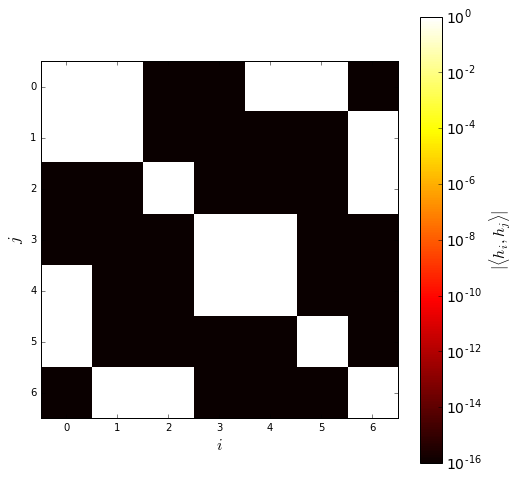

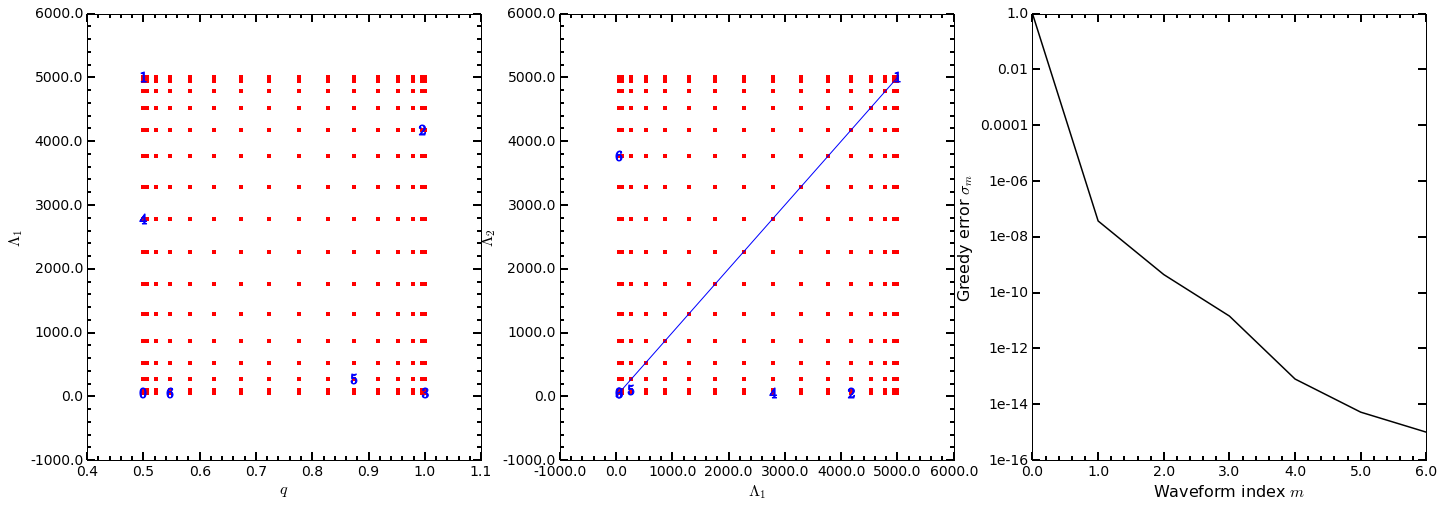

In [14]:
inner = diagnostics.check_orthonormality(rbphaserun.rb, inner_product)

fig = plt.figure(figsize=(24, 8))

axes = fig.add_subplot(131)
diagnostics.plot_parameters(axes, 0, 1, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$q$', ylabel=r'$\Lambda_1$')

axes = fig.add_subplot(132)
diagnostics.plot_parameters(axes, 1, 2, ts_params=rbphaserun.ts_params, rb_params=rbphaserun.rb_params, 
                xlabel=r'$\Lambda_1$', ylabel=r'$\Lambda_2$')
axes.plot([0, 5000], [0, 5000])

axes = fig.add_subplot(133)
diagnostics.plot_greedy_error(axes, rbphaserun.sigma_list)

# Generate empirical nodes

In [15]:
memb_size=2**34-1

#filename = '../data/teob_rbamp_smallq_cheb_3_%d.hdf5'
#filename = '../data/teob_rbamp_smallq_cheb_9_%d.hdf5'
filename = '../data/teob_rbamp_smallq_cheb_16_%d.hdf5'
rbamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

#filename = '../data/teob_rbphase_smallq_cheb_3_%d.hdf5'
#filename = '../data/teob_rbphase_smallq_cheb_9_%d.hdf5'
filename = '../data/teob_rbphase_smallq_cheb_16_%d.hdf5'
rbphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

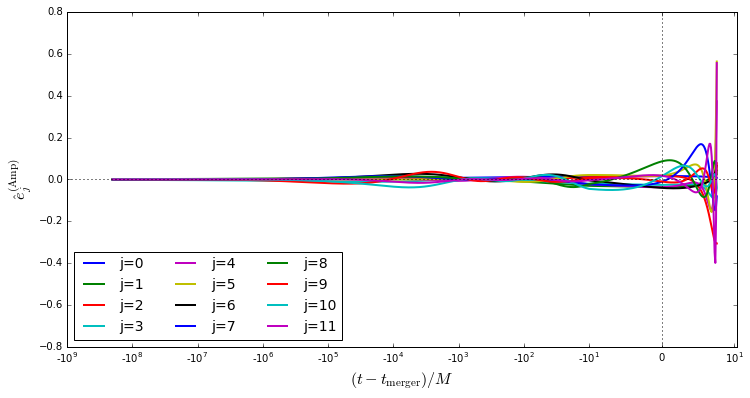

In [16]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(rbamp.get_len()):
    h = rbamp.get_waveform_data(j)
    axes.plot(h.time, h.amp, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_ylim([-0.8, 0.8])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.0001)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)

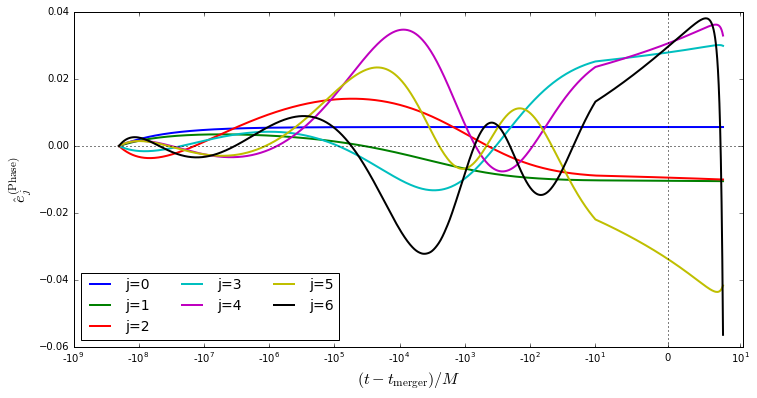

In [17]:
fig = plt.figure(figsize=(12, 6))

axes = fig.add_subplot(111)
for j in range(rbphase.get_len()):
    h = rbphase.get_waveform_data(j)
    axes.plot(h.time, h.phase, lw=2, label='j='+str(j))
axes.axhline(0.0, color='k', ls=':')
axes.axvline(0.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
#axes.set_ylim([-0.1, 0.1])
axes.set_xscale('symlog', linthreshx=10.0)
#axes.set_yscale('symlog', linthreshx=0.01)

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$\hat e^{\rm (Phase)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)
#fig.savefig('/home/bdlackey/public_html/ROM/RBphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [18]:
empirical_node_indices_amp, Bamp_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbamp, 'amp')
empirical_node_indices_phase, Bphase_j = tdrom.empirical_interpolation_for_time_domain_waveform(rbphase, 'phase')

In [19]:
# Store interpolating functions in HDF5TimeDomainWaveformSet object

# Amplitude
memb_size=2**26-1

#filename = '../data/Bamp_cheb_3_%d.hdf5'
#filename = '../data/Bamp_cheb_9_%d.hdf5'
filename = '../data/Bamp_cheb_16_%d.hdf5'
Bamp = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bamp.set_grid_shape(shape=None)
Bamp.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bamp.add_waveform_list(Bamp_j, [[0.0, 0.0, 0.0]]*len(Bamp_j))
Bamp.close()

# Phase
#filename = '../data/Bphase_cheb_3_%d.hdf5'
#filename = '../data/Bphase_cheb_9_%d.hdf5'
filename = '../data/Bphase_cheb_16_%d.hdf5'
Bphase = tdwave.HDF5TimeDomainWaveformSet(filename, mode='x', memb_size=memb_size)
Bphase.set_grid_shape(shape=None)
Bphase.set_parameter_names(['q', 'LambdaA', 'LambdaB'])
Bphase.add_waveform_list(Bphase_j, [[0.0, 0.0, 0.0]]*len(Bphase_j))
Bphase.close()

In [20]:
memb_size=2**26-1

#filename = '../data/Bamp_cheb_3_%d.hdf5'
#filename = '../data/Bamp_cheb_9_%d.hdf5'
filename = '../data/Bamp_cheb_16_%d.hdf5'
Bamp = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

#filename = '../data/Bphase_cheb_3_%d.hdf5'
#filename = '../data/Bphase_cheb_9_%d.hdf5'
filename = '../data/Bphase_cheb_16_%d.hdf5'
Bphase = tdwave.load_hdf5_time_domain_waveform_set(filename, memb_size=memb_size)

In [21]:
Bamp_list = [Bamp.get_waveform_data(i) for i in range(Bamp.get_len())]
Bphase_list = [Bphase.get_waveform_data(i) for i in range(Bphase.get_len())]

In [22]:
Bamp.close()
Bphase.close()

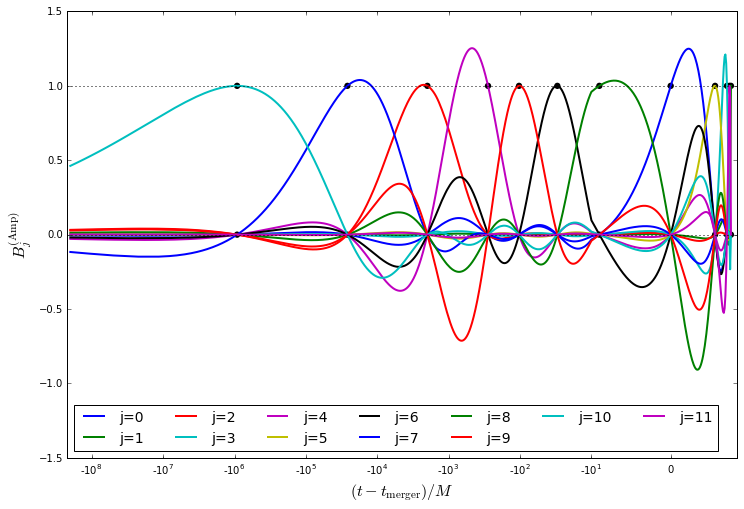

In [23]:
fig = plt.figure(figsize=(12, 8))
axes = fig.add_subplot(111)

for j in range(len(Bamp_list)):
    h = Bamp_list[j]
    axes.plot(h.time, h.amp, lw=2, label='j='+str(j))

axes.axhline(y=0.0, color='k', ls=':')
axes.axhline(y=1.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_xlim([1.1*h.time[0], 1.1*h.time[-1]])
axes.set_xscale('symlog', linthreshx=10.0)

indices = empirical_node_indices_amp
htime = h.time[indices]
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Amp)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=7)

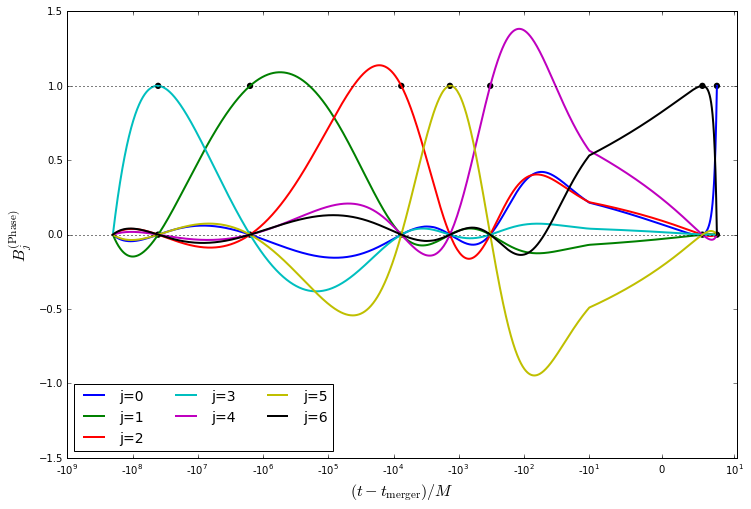

In [24]:
fig = plt.figure(figsize=(12, 8))
axes = fig.add_subplot(111)

for j in range(len(Bphase_list)):
    h = Bphase_list[j]
    axes.plot(h.time, h.phase, lw=2, label='j='+str(j))

axes.axhline(y=0.0, color='k', ls=':')
axes.axhline(y=1.0, color='k', ls=':')
axes.set_xlim([-1.0e9, 11.0])
axes.set_xscale('symlog', linthreshx=10.0)

indices = empirical_node_indices_phase
htime = h.time[indices]
axes.scatter(htime, 0*htime, marker='o', c='k', s=40, edgecolor='none')
axes.scatter(htime, 0*htime+1, marker='o', c='k', s=40, edgecolor='none')

axes.set_xlabel(r'$(t-t_{\rm merger})/M$', fontsize=16)
axes.set_ylabel(r'$B^{\rm (Phase)}_j$', fontsize=16)
axes.legend(fontsize=14, loc='lower left', ncol=3)
#fig.savefig('/home/bdlackey/public_html/ROM/Bphase.pdf', format='pdf', transparent=True, bbox_inches='tight')

# Interpolate training set amp and phase at empirical nodes

In [25]:
# This extracts each training set waveform from the HD, so it will take several minutes.
train_amp_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_amp, 'amp')
train_phase_at_nodes = tdrom.waveform_data_at_empirical_nodes(ts, empirical_node_indices_phase, 'phase')

In [26]:
param_grid = ts.get_parameter_grid()

# Turn amp-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_amp_at_nodes[0])
train_amp_grid_list = []
for i in range(Nnodes):
    amp_grid = train_amp_at_nodes[:, i].reshape(shape)
    train_amp_grid_list.append(amp_grid)
    
# Turn phase-at-empirical-nodes to list-of-grids
shape = tuple(ts.grid_shape)
Nnodes = len(train_phase_at_nodes[0])
train_phase_grid_list = []
for i in range(Nnodes):
    phase_grid = train_phase_at_nodes[:, i].reshape(shape)
    train_phase_grid_list.append(phase_grid)

In [27]:
params_min = param_grid[0, 0, 0]
params_max = param_grid[-1, -1, -1]
amp_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_amp_grid_list, params_min, params_max)
phase_coeff_list = cheb.chebyshev_coefficient3d_list_generator(train_phase_grid_list, params_min, params_max)

In [28]:
print len(amp_coeff_list), amp_coeff_list[0].shape
print len(phase_coeff_list), phase_coeff_list[0].shape

12 (16, 16, 16)
7 (16, 16, 16)


In [29]:
#filename = '../data/amp_coeffs_cheb_3.hdf5'
#filename = '../data/amp_coeffs_cheb_9.hdf5'
filename = '../data/amp_coeffs_cheb_16.hdf5'
coefficients_list = amp_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

#filename = '../data/phase_coeffs_cheb_3.hdf5'
#filename = '../data/phase_coeffs_cheb_9.hdf5'
filename = '../data/phase_coeffs_cheb_16.hdf5'
coefficients_list = phase_coeff_list
cheb.save_chebyshev_coefficients_list(filename, coefficients_list, params_min, params_max)

# Load ROM

In [4]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

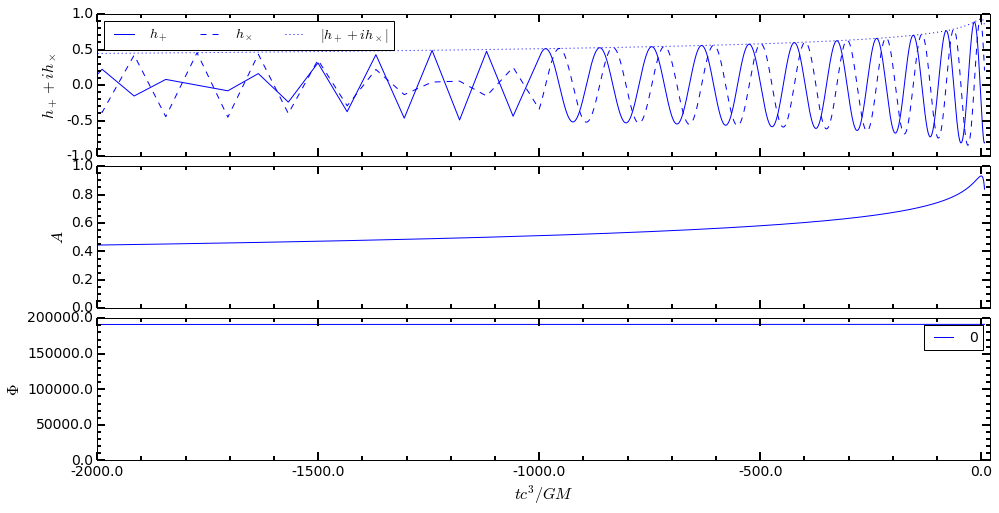

In [5]:
params = [0.9, 501, 500]
waveforms = rom.evaluate(params)

xlim=[-2000, 20]
fig = plt.figure(figsize=(16, 8))
tdwave.plot_time_domain_waveform_list(fig, waveforms, imag=True, mag=True, 
                               xlim=xlim, xlabel=r'$tc^3/GM$',
                               ylabel_pol=r'$h_+ + i h_\times$', 
                               ylabel_amp=r'$A$', ylabel_phase=r'$\Phi$', 
                               pol_legend=True)

In [6]:
len(waveforms.time)

73624